In [1]:
from random import *
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from random import uniform
import random
import warnings
from statistics import mean

In [2]:
class Chromosome:
    def __init__(self, problParam=None):
        self.__problParam = problParam
        possible = [i for i in range(problParam['min'], problParam['max'] + 1)]
        self.__repres = [choice(possible) for _ in range(problParam['noDim'])]
        self.__fitness = 0.0

    @property
    def repres(self):
        return self.__repres

    @property
    def fitness(self):
        return self.__fitness

    @repres.setter
    def repres(self, l=[]):
        if l:
            self.__fitness = self.__problParam["function"](l, self.__problParam["net"])
        self.__repres = l

    @fitness.setter
    def fitness(self, fit=0.0):
        self.__fitness = fit

    def crossover(self, c):
        r = randint(0, len(self.__repres) - 1)
        newrepres = []
        for i in range(r):
            newrepres.append(self.__repres[i])
        for i in range(r, len(self.__repres)):
            newrepres.append(c.__repres[i])
        offspring = Chromosome(c.__problParam)
        offspring.repres = newrepres
        return offspring

    def mutation(self):
        pos = randint(0, len(self.__repres) - 1)
        possible = [i for i in range(self.__problParam['min'], self.__problParam['max'] + 1)]
        self.__repres[pos] = choice(possible)
        self.__fitness = self.__problParam["function"](self.__repres, self.__problParam['net'])

    def __str__(self):
        return '\nChromo: ' + str(self.__repres) + ' has fit: ' + str(self.__fitness)

    def __repr__(self):
        return self.__str__()

    def __eq__(self, c):
        return self.__repres == c.__repres and self.__fitness == c.__fitness

In [3]:
def modularity(communities, param):
    noNodes = param['noNodes']
    mat = param['mat']
    degrees = param['degrees']
    noEdges = param['noEdges']
    M = 2 * noEdges
    Q = 0.0
    for i in range(0, noNodes):
        for j in range(0, noNodes):
            if communities[i] == communities[j]:
                Q += (mat[i][j] - degrees[i] * degrees[j] / M)
    return Q * 1 / M

In [4]:
# Diferenta dintre modularitatea simpla si aceasta este faptul ca aceasta incearca sa gaseasca si comunitatile mici
# din comunitatile mari. Parametrul myLambda, care este default 0.5, ne spune cat de dens este graful:  0 - nu exista
# muchii, 1 - e graf complet.
def modularity_density(communities, param, myLambda=0.5):
    G = nx.from_numpy_array(np.matrix(param['mat']))
    my_communities = [[] for _ in range(param['noNodes'])]
    for i in range(param['noNodes']):
        my_communities[communities[i] - 1].append(i)
    Q = 0.0
    for community in my_communities:
        sub = nx.subgraph(G, community)
        sub_n = sub.number_of_nodes()
        interior_degrees = []
        exterior_degrees = []
        for node in sub:
            interior_degrees.append(sub.degree(node))
            exterior_degrees.append(G.degree(node) - sub.degree(node))
        try:
            Q += (1 / sub_n) * (
                        (2 * myLambda * np.sum(interior_degrees)) - (2 * (1 - myLambda) * np.sum(exterior_degrees)))
        except ZeroDivisionError:
            pass
    return Q

In [5]:
# Incearca, de asemenea, sa evite limita de rezolutie, gasind si comunitatile mici din comunitatile mari.
# Se bazeaza pe distributia Student - se calculeaza raritatea statistica a unei comunitati.
def z_modularity(communities, param):
    G = nx.from_numpy_array(np.matrix(param['mat']))
    my_communities = [[] for _ in range(param['noNodes'])]
    for i in range(param['noNodes']):
        my_communities[communities[i] - 1].append(i)
    edges = G.number_of_edges()
    Q = 0.0
    mmc = 0
    dc2m = 0
    for community in my_communities:
        sub = nx.subgraph(G, community)
        sub_n = sub.number_of_nodes()
        dc = 0
        for node in sub:
            dc += G.degree(node)
        mmc = sub_n / edges
        dc2m += (dc / (2 * edges)) ** 2
    try:
        Q = (mmc - dc2m) / np.sqrt(dc2m * (1 - dc2m))
    except ZeroDivisionError:
        pass
    return Q

In [6]:
def plotNetwork(net, com=None):
    if com is None:
        com = [1] * net['noNodes']
    np.random.seed(123)
    A = np.matrix(net["mat"])
    G = nx.from_numpy_array(A)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(5, 5))
    nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.get_cmap('viridis', 12), node_color=com)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    plt.show()

In [7]:
def readNetworkFromGml(file):
    gmlNet = nx.read_gml(file, label="id")
    mat = nx.adjacency_matrix(gmlNet)
    matrix = [[0] * len(gmlNet.nodes) for _ in range(len(gmlNet.nodes))]
    tmp = mat.nonzero()
    for i in range(len(tmp[0])):
        matrix[tmp[0][i]][tmp[1][i]] = 1
    net = {
        'noNodes': len(gmlNet.nodes),
        'mat': matrix,
        'noEdges': len(gmlNet.edges),
        'degrees': [degree[1] for degree in gmlNet.degree()]
    }

    return net


In [8]:
warnings.simplefilter("ignore")

def ga(network, modularity_function, no_communities):
    problem_parameters = {
        "min": 1,
        "max": no_communities,
        "noDim": network["noNodes"],
        "net": network,
        "function": modularity_function
    }
    noChromosomes = network["noNodes"]
    chromosomes = []
    for _ in range(noChromosomes):
        ch = Chromosome(problem_parameters)
        ch.fitness = problem_parameters["function"](ch.repres, network)
        chromosomes.append(ch)

    generations = 1000
    averageValues = []
    minimumValues = []
    maximumValues = []
    yPoints = []
    for i in range(generations):
        initLen = len(chromosomes)
        for _ in range(initLen):
            a = random.randint(0, initLen - 1)
            b = random.randint(0, initLen - 1)
            ch = chromosomes[a].crossover(chromosomes[b])
            chromosomes.append(ch)

        for ch in chromosomes:
            ch.mutation()

        chMax = max(chromosomes, key=lambda x: x.fitness)
        chMin = min(chromosomes, key=lambda x: x.fitness)
        chroms = [x.fitness for x in chromosomes]
        chAvg = mean(chroms)

        yPoints.append(i)
        maximumValues.append(chMax.fitness)
        minimumValues.append(chMin.fitness)
        averageValues.append(chAvg)

        # print(chMin.fitness, chMax.fitness, chAvg)

        chromosomes = sorted(chromosomes, key=lambda x: x.fitness, reverse=True)[:initLen]

    import matplotlib.pyplot as plt

    plt.plot(yPoints, minimumValues, label="Minimum")
    plt.plot(yPoints, averageValues, label="Average")
    plt.plot(yPoints, maximumValues, label="Maximum")
    plt.legend()
    plt.show()

    ch = max(chromosomes, key=lambda x: x.fitness)
    # print(ch)
    if len(ch.repres) < 200:
        plotNetwork(network, ch.repres)
    else:
        print(len(ch.repres))
    

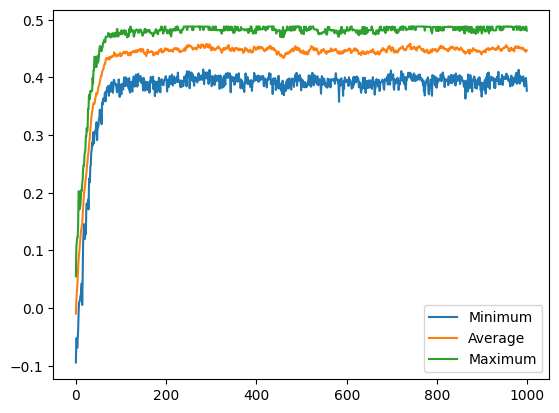

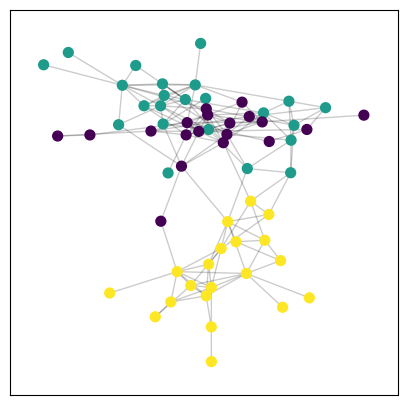

In [17]:
net = readNetworkFromGml("data/real/dolphins/dolphins.gml")
ga(net, modularity, 3)

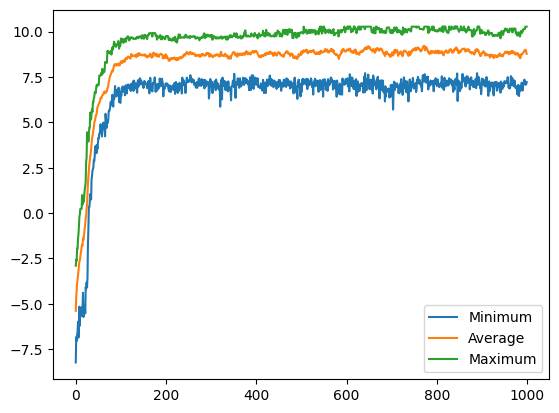

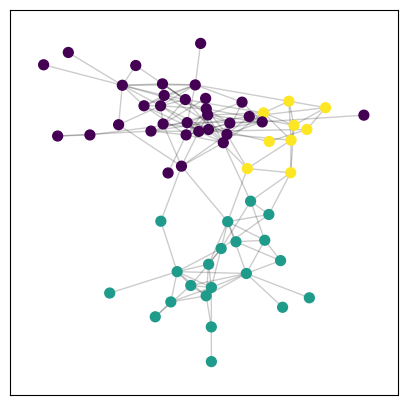

In [18]:
ga(net, modularity_density, 3)

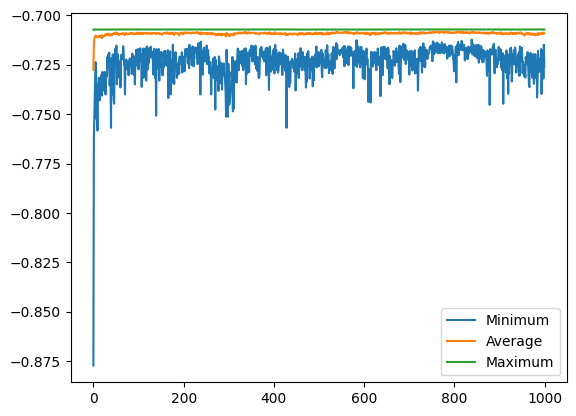

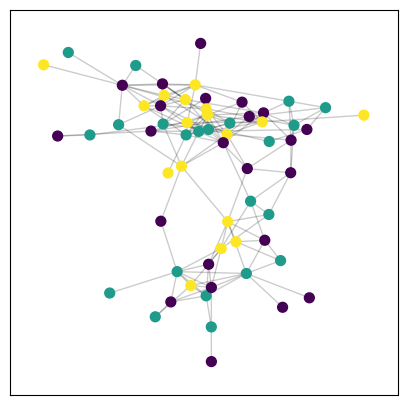

In [19]:
ga(net, z_modularity, 3)

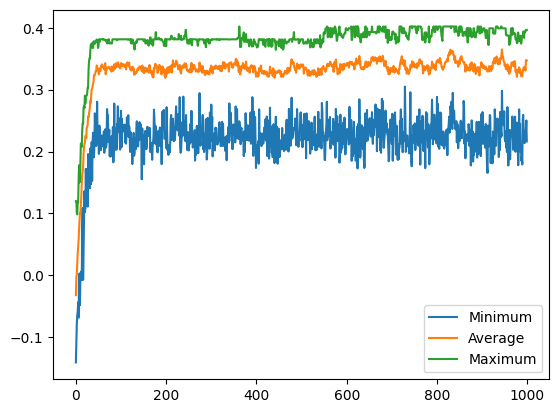

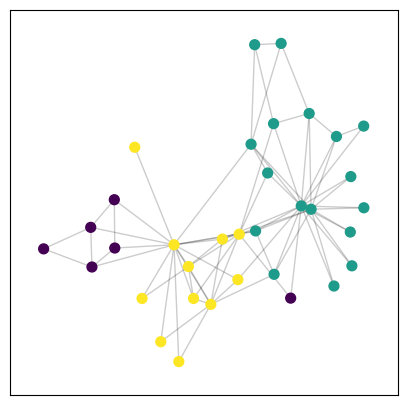

In [20]:
# 2. Karate
net = readNetworkFromGml("data/real/karate/karate.gml")
ga(net, modularity, 3)

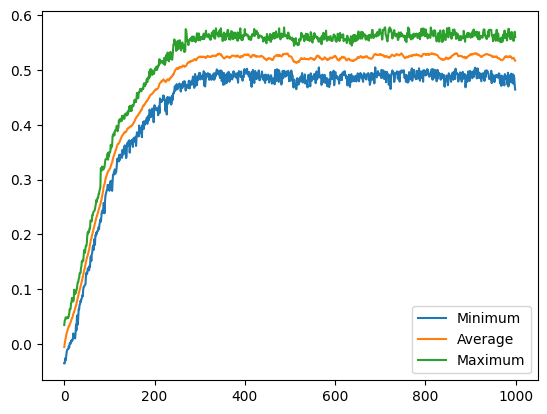

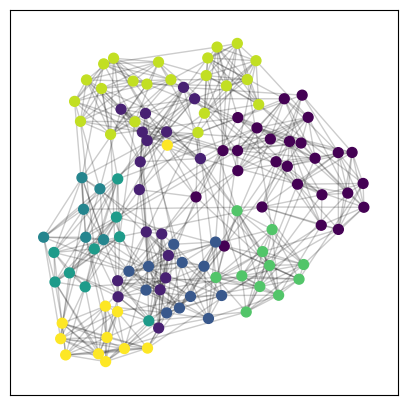

In [21]:
# 3. Football
net = readNetworkFromGml("data/real/football/football.gml")
ga(net, modularity, 8)

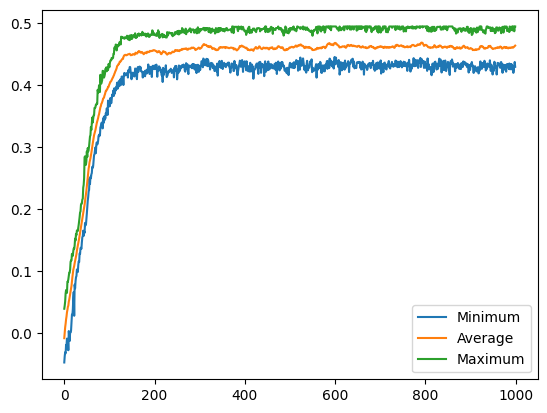

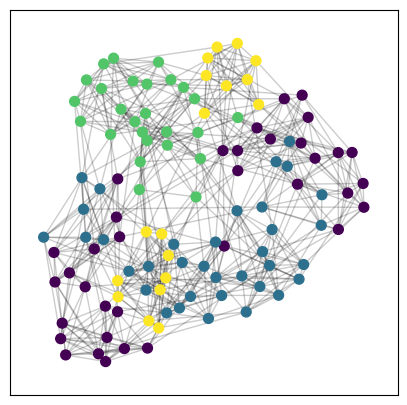

In [22]:
# 4. Krebs
net = readNetworkFromGml("data/real/football/football.gml")
ga(net, modularity, 4)

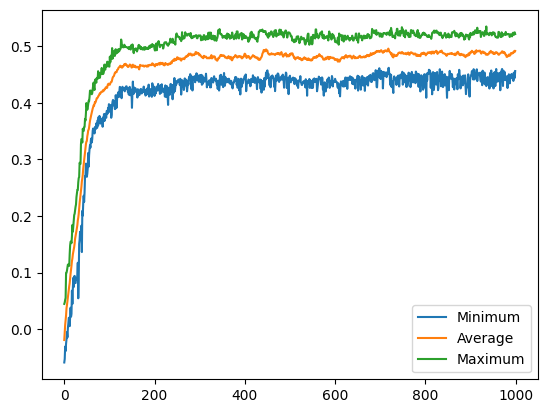

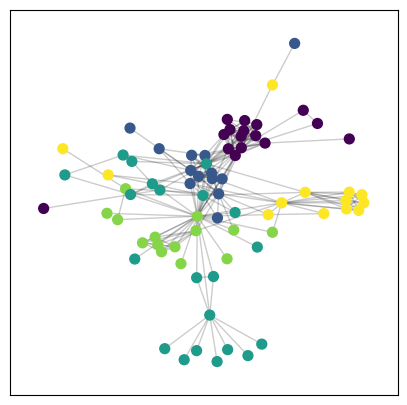

In [23]:
# 5. Les Miserables
net = readNetworkFromGml("data/myData/lesMiserables/lesmis.gml")
ga(net, modularity, 5)

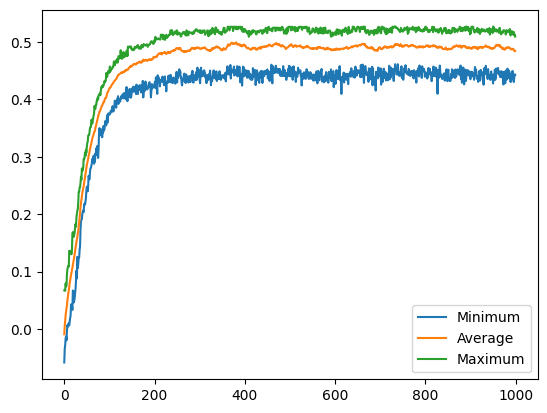

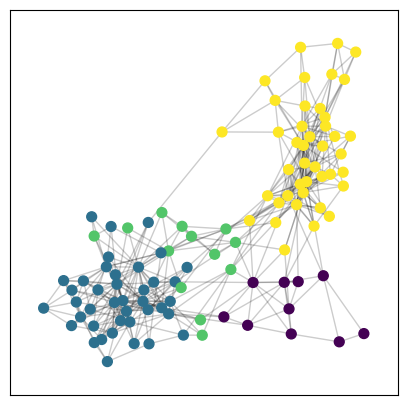

In [24]:
# 6.Books about US politics:
net = readNetworkFromGml("data/myData/politicalBooks/polBooks.gml")
ga(net, modularity, 4)

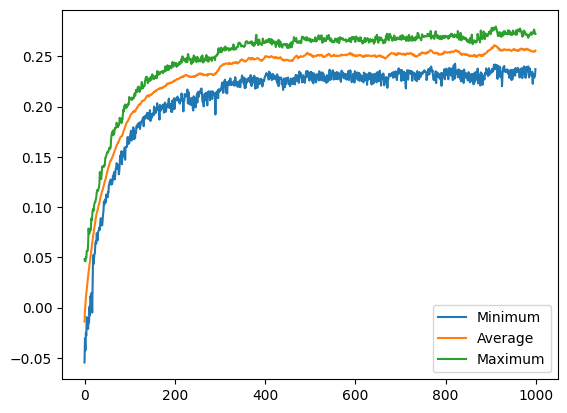

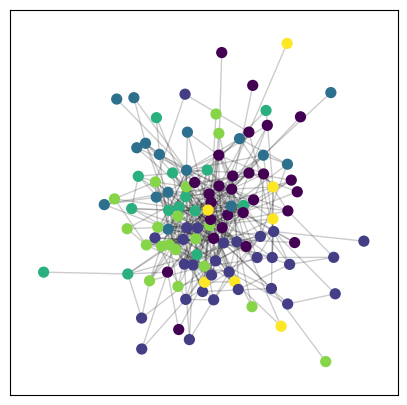

In [25]:
# 7. Word adjacencies:
net = readNetworkFromGml("data/mydata/wordAdjacencies/adjnoun.gml")
ga(net, modularity, 6)

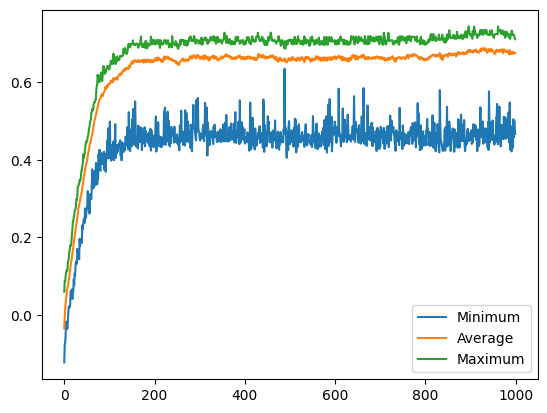

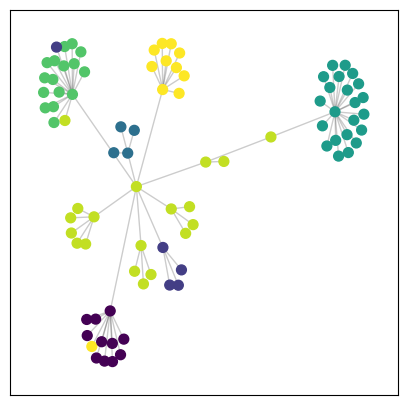

In [26]:
# 8. Lobster
net = readNetworkFromGml("data/myData/lobster/lobster.gml")
ga(net, modularity, 7)

In [ ]:
# 9.Power grid: 
net = readNetworkFromGml("data/myData/powerGrid/power.gml")
ga(net, modularity, 38)

In [ ]:
# 10. Internet
net = readNetworkFromGml("data/myData/internet/as-22july06.gml")
ga(net, modularity, 39)